# Group5_Resume_Tracking_System


#### Anand Pratap Singh (12020084)
#### Francis David Vuppuluri (12020028)
#### Lavanya SN (12020075)
#### Puneet Srivastava (12020026)
#### Sangeeta Thakur (12020088)

In [66]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import utils.simplifiedSkillList
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#read test data
df = pd.read_csv('./data/PreNLPData.tsv', sep='\t')

# remove garbage data
df = df[df['Skillset'] != '[]']
df = df[df['Salary'] != 1]

# reset index
df = df.reset_index().drop('index', axis = 1)

In [ ]:
# initialize a dict that keeps a track of all skills replaced and by which word
trackingDict = dict()

# function that replaces the matched skill with the term we want to replace,
# essentially a simplified representation of that skill
def simplifySkillset(skillstring, searchstring, replacestring):
    tempList = list()
    skillList = skillstring.replace('[','').replace(']','').replace("'","").split(', ')
    for skill in skillList:
        skill = re.sub('[^A-Za-z ]+', '', skill) # remove special characters
        skill = skill.replace('management', '').strip() # replace the word  "management"
        skill = " ".join(skill.split()) # remove any extra spaces
        if skill.strip() != "":
            if searchstring in skill.lower().strip():
                tempList.append(replacestring) # replace if the search string is found
                trackingDict[skill.lower().strip()] = replacestring # append to the tracker dictionary
            else:
                tempList.append(skill.lower().strip()) # keep the original skill

    return ", ".join(tempList)


# get the list of skills from a reference file present in utils folder
replaceList = utils.simplifiedSkillList.replaceList

for i in replaceList:
    search = i # search for the string
    replace = i # replace the searched string by this
    df['Skillset'] = df['Skillset'].map(lambda x: simplifySkillset(x, search, replace))

In [30]:
# initialize a list to keep a track of comma seperated tokens(skills) to be used to calculate TF-IDF scores
tokenized_list_of_sentences = list()

# function for tokenization
def createTokenizedListOfSentences(skillString):
    tokenized_list_of_sentences.append([skill.strip() for skill in skillString.split(', ')])
    return True

df['Skillset'].map(lambda x: createTokenizedListOfSentences(x))

0        True
1        True
2        True
3        True
4        True
         ... 
25709    True
25710    True
25711    True
25712    True
25713    True
Name: Skillset, Length: 25714, dtype: bool

In [31]:
# as the skills are comma seperated, 
# I am passing comma seperated tokens, instead of complete documents
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer,  
                        max_features=1000, 
                        stop_words='english', 
                        lowercase=False)    

# create a sparse matrix of top 1000 features on the skill tokens
tfidf_matrix = tfidf.fit_transform(tokenized_list_of_sentences)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [32]:
# let's put the tfidf in a dataframe and see how it looks
tfidfDf = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf.get_feature_names())

In [11]:
tfidfDf.head()

,acad,accenture,access,accessibility,account,active directory,ad,adc,adls,admin,...,working drawings,wpf,writing skills,written,x,xml,yii,zen,zoho,zomato
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#####  Clearly the dataframe is heavily sparsed, but one can see how it is populated with TF-IDF values for different words in a document

In [33]:
# Now we initialize an SVD of 300 components, 
# which basically decomposes the 1000 vectors in tf-idf dataframe to 300 vectors 
# that explains the a significant percentage of variance in data
svdT = TruncatedSVD(n_components=300)
svdTFit = svdT.fit(tfidf_matrix)

In [34]:
# the following line shows the percentage of variance explained by 300 components 
# made out of 1000 features
sum(svdTFit.explained_variance_)

0.8698511308113908

In [35]:
# create a dataframe that can be used for training a model
finalDf = pd.DataFrame(svdTFit.transform(tfidf_matrix)) # 300 vectors
finalDf['Experience'] = df['Experience'] # numerical value of experience

# hot encoding of regions
finalDf['North'] = df['Zone'].map(lambda x: 1 if 'north' in x else 0) 
finalDf['East'] = df['Zone'].map(lambda x: 1 if 'east' in x else 0) 
finalDf['West'] = df['Zone'].map(lambda x: 1 if 'west' in x else 0) 
finalDf['South'] = df['Zone'].map(lambda x: 1 if 'south' in x else 0) 

finalDf['Salary'] = df['Salary']/100000 # scaling of salary by converting the value "in lakhs"

<AxesSubplot:>

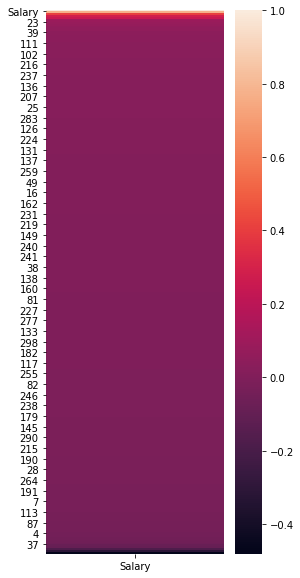

In [36]:
# let's have a look at the correlation between salary and other 305 columns
x = finalDf.corr()[['Salary']] 

# let's visualize it
plt.figure(figsize=(4,10))
sns.heatmap(x.sort_values(by='Salary', ascending=False))       

##### most of the features have low correlation, except for a few on the etreme ends

In [17]:
finalDf.to_csv('./data/finalDf.csv', index=False)

----------------------------------------------------------

## Regression Model

In [37]:
Data = finalDf

<AxesSubplot:>

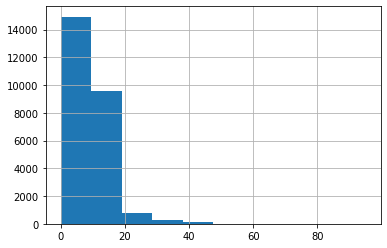

In [38]:
Data.Salary.hist()

In [59]:
## Regression

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# **Create X and y**
y_col = "Salary"

X = Data.drop(y_col, axis=1)
y = Data[y_col]

# **Train test split**
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=72018)


results_df = pd.DataFrame()
columns = ["Model", "Cross Val Score", "MAE", "MSE", "RMSE", "R2"]

# function that calculates different metrics
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# club the results togther
def append_results(model_name, model, results_df, y_test, pred):
    results_append_df = pd.DataFrame(data=[[model_name, 
                                            *evaluate(y_test, pred), 
                                            cross_val_score(model, X, y, cv=10).mean()]], 
                                     columns=columns)
    
    results_df = results_df.append(results_append_df, ignore_index = True)
    return results_df


# initializing a regression modela
lin_reg = LinearRegression(normalize=True)
# training
lin_reg.fit(X_train,y_train)

# prediction
pred = lin_reg.predict(X_test)

results_df = append_results("Linear Regression",  LinearRegression(), results_df, y_test, pred)

In [60]:
print(results_df)

               Model  Cross Val Score      MAE       MSE      RMSE        R2
0  Linear Regression         1.394546  12.7896  3.576255  0.750325  0.780562


#### RMSE of 0.75 or 77000 rupees
#### R2 of 0.78 indicates that 22% of the variability in the outcome data cannot be explained by the model

### Just to see how our model has worked

In [61]:
# read the actual training data
trainDf = pd.read_csv('./data/SimplifiedTrainData.tsv', sep='\t')

# 
trainDf.drop(['Skillset', 'Salary'], axis=1, inplace = True)

actualTrainDf = trainDf.iloc[X_test.index, :]

actualTrainDf['Actual Salary'] = y_test
actualTrainDf['Predicted Salary'] = pred

<ipython-input-61-f707fe768b33>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actualTrainDf['Actual Salary'] = y_test
<ipython-input-61-f707fe768b33>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actualTrainDf['Predicted Salary'] = pred


In [62]:
actualTrainDf.head()

,Title,Company,Experience,Zone,Simplified Skillset,Actual Salary,Predicted Salary
23555,SAP Data Migration Consultant - LOG,Atos Syntel,8.0,"{'south', 'west'}","log, sap, app, quality, data migration, analyt...",12.0,17.533667
24339,Portfolio Manager/ Senior Sales Manager (T1),Square Yards Consulting Private Limited,4.0,{'west'},"sales, bde, portfolio management, bdm, sales, ...",10.0,7.042393
4502,"Russian Language - Read, Write & Speak",GlobalLogic Technologies Limited,1.5,"{'south', 'east', 'west', 'north'}","communication, written, russian, russian, russ...",3.0,2.999866
19973,Desktop Support Engineer,Steno House,4.5,{'north'},NaN,6.5,9.657918
10630,Urgently looking For CPQ Technical Consultant,Virtusa Consulting Services Pvt Ltd,8.5,"{'south', 'west'}","communication, java, soap, html, java, cpq, or...",18.0,17.975743


------------------------------------------------------

## Test Data

In [63]:
testdf = pd.read_csv('./data/finalTestData.tsv', sep='\t')

testdf.rename(columns={'Top Skills': 'Skillset'}, inplace = True)

testdf = testdf[~testdf['Skillset'].isna()]

testdf = testdf.reset_index().drop('index', axis=1)

trackingDict = dict()

replaceList = utils.simplifiedSkillList.replaceList

for i in replaceList:
    search = i
    replace = i
    testdf['Skillset'] = testdf['Skillset'].map(lambda x: simplifySkillset(x, search, replace))

tokenized_list_of_sentences = list()

testdf['Skillset'].map(lambda x: createTokenizedListOfSentences(x))

0     True
1     True
2     True
3     True
4     True
      ... 
79    True
80    True
81    True
82    True
83    True
Name: Skillset, Length: 84, dtype: bool

In [64]:
finalTestDf = pd.DataFrame(svdTFit.transform(tfidf.transform(tokenized_list_of_sentences)))
finalTestDf['Experience'] = testdf['Experience']
finalTestDf['North'] = testdf['Zone'].map(lambda x: 1 if 'north' in x else 0) 
finalTestDf['East'] = testdf['Zone'].map(lambda x: 1 if 'east' in x else 0) 
finalTestDf['West'] = testdf['Zone'].map(lambda x: 1 if 'west' in x else 0) 
finalTestDf['South'] = testdf['Zone'].map(lambda x: 1 if 'south' in x else 0) 

finalTestDf = finalTestDf[~finalTestDf['North'].isna()]

testPredLR = lin_reg.predict(finalTestDf)

testdf['Salary LR'] = testPredLR

testdf.to_csv('./data/PredictSalaryEnriched.tsv', sep='\t', index=False)

In [65]:
testdf

,Index,Skillset,Experience,Zone,Salary LR
0,C1,"human resources hr, microsoft, strategic plann...",1,{'west'},8.140180
1,C2,"market, vendor, strategic sourcing, product, b...",8,{'north'},16.683021
2,C3,"leadership, research, team, data analys, stati...",2,"{'east', 'south'}",9.465278
3,C4,"c, linux, microsoft, excel",8,"{'north', 'east', 'west', 'south'}",20.766641
4,C5,"excel, python, sql, project, analytics, model,...",1,"{'north', 'east', 'west', 'south'}",11.952706
...,...,...,...,...,...
79,C88,"dynamic, sme, interpersonal leadership, requir...",4,{'west'},7.704403
80,C89,"analytics, business, sas, analytics, data ware...",14,{'north'},33.225480
81,C90,"financ, team, business, financ, business, fina...",10,{'west'},18.180636
82,C91,"data analys, data analys, python, project, hum...",11,{'south'},24.416853
